In [18]:
import numpy as np
import pandas as pd
import utils

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

pd.options.display.max_info_columns=250
pd.options.display.max_columns=500
pd.options.display.max_rows=100

# Silence future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

___
# Get to know the CHIFIR dataset

_The corpus of Cytology and Histopathology Invasive Fungal Infection Reports (CHIFIR) is available at [PhysioNet](https://physionet.org/content/corpus-fungal-infections/1.0.0/). Since these are medical reports and can contain sensitive information, the dataset can only be accessed by credentialed users who have signed the Data Use Agreement._

___
## Background

Cytology and histopathology reports are a common type of clinical documentation. These are pathologist-produced free-text reports outlining the macroscopic and microscopic structure of a specimen. Depending on the sample and what it contains, a report might describe its overall structure, which types cells or tissue can be seen, and any pathological findings. In other words, the information contained in a report can vary a lot and directly depends on the patient's medical condition.  

CHIFIR was created to support the development of an automated tool for the detection of invasive fungal infection (IFI). IFIs are rare but serious infections most commonly affecting immunocompromised and critically ill patients. Traditionally, surveillance of IFI is a laboriuos process which requires a physician to perform a detailed review of patient's medical history. Histopathology reports play a key role as they provide, albeit not with 100% certainty, evidence for the presence or absence of IFI.

___
## Aim

As mentioned above, the ultimate goal is to build a tool that can accurately detect IFI based on a patient's medical history. Part of this is to be able to tell if any associated histopathology reports contain any evidence for IFI. This can be done in two steps:
- By extracting any relevant information from a report, e.g., phrases describing fungal organisms.
- Based on this information, classifying a report as positive or negative for IFI.

In this tutorial, we will be focussing on the task of information extraction, specifically, named-entity recognition (NER). This means we would like to **detect words or phrases in the text that describe a particular concept**. Since the reports are free-text, we might need to use text analytics and natural language processing (NLP) methods. But first let's take a look at the data...

___
# Explore the CHIFIR dataset

___
## Metadata

In [2]:
# Load the csv file with report metadata
path = "../../../Data/CHIFIR/"
df = pd.read_csv(path + "chifir_metadata.csv")
print(df.shape)
df.head()

(283, 6)


,patient_id,report_no,y_report,histopathology_id,val_fold,dataset
0,13,1,Positive,658,10.0,development
1,14,1,Positive,189,7.0,development
2,28,1,Negative,529,8.0,development
3,28,2,Positive,325,8.0,development
4,28,3,Negative,559,8.0,development


In [3]:
# How many reports?
df.histopathology_id.nunique()

283

In [4]:
# Number of patients
df.patient_id.nunique()

201

In [5]:
# Number of reports per patient
df.groupby('patient_id').size().aggregate(['min', 'max'])

min    1
max    6
dtype: int64

In [6]:
# Report-level annotations
df.y_report.value_counts()

y_report
Negative    243
Positive     40
Name: count, dtype: int64

In [7]:
# Proportion of positive reports
df.y_report.value_counts(normalize=True).round(2)

y_report
Negative    0.86
Positive    0.14
Name: proportion, dtype: float64

In [8]:
# Recommended data split: development and test sets
df.dataset.value_counts()

dataset
development    231
test            52
Name: count, dtype: int64

In [9]:
# Recommended data split for 10-fold cross-validation --
# ensures reports from the same patient are allocated to the same fold.
df[df.dataset=='development'].val_fold.value_counts().sort_index()

val_fold
1.0     21
2.0     19
3.0     19
4.0     30
5.0     19
6.0     26
7.0     29
8.0     29
9.0     18
10.0    21
Name: count, dtype: int64

<div class="alert alert-block alert-info">
<b>Tip:</b> Use the same cross-validation split to compare different models/approaches otherwise your results might not be reliable. Here, we appended fold numbers to the dataset; you can also reproduce the splitting strategy each time but make sure to initialise the random number generator with the same value.
</div>

___
## Reports

In [10]:
# Add free-text reports to the dataframe
df['report'] = df.apply(utils.read_report, path=path + "reports/", axis=1)

In [11]:
# What does a report look like? Let's look at an example
print(df.report.iloc[20])

"URNO     XXXXXXXXX 
Lab No    XXXXXXXXX        Specimen  CEREBROSPINAL FLUID 


SPECIMEN 
CSF 

REQUEST DETAILS 
Stage IV FL- on bispecific Ab. Noted Cryptococcus isolate in left pleural lesion and positive serum cryptococcal Ag. Exclude CNS involvement. 

MACROSCOPIC DESCRIPTION 
Specimen labelled with patient details and "" XXX 1440 (2) ward XX"" 
3ml clear colourless fluid, 4 Giemsa slides prepared (Additional 2 Giemsa slide prepared from remainder of volume) 
(HR XXXXXXXXX) 

MICROSCOPIC DESCRIPTION 
The slides show mature lymphocytes and monocytes. There are rare red blood cells in the background. No organisms are seen with a Giemsa stain. No atypical cells are seen. 

OPINION 
CSF - No organisms seen. Negative for malignancy. 


Reported by Dr XXXXXXXXXX with Dr XXXXXXXXX, XXXXXXXXXXXXXXXXXXXXXXXXXXXXX, validated XXXXXXXXXXX "



<div class="alert alert-block alert-info">
<li>Personal identifiying information is replaced with a string of Xs of equal length.
    
<code>"Reported by Dr XXXXXXXXXX with Dr XXXXXXXXX, XXXXXXXXXXXXXXXXXXXXXXXXXXXXX, validated XXXXXXXXXXX "</code></li>
<li>Report sections are separated by newline characters and headers in caps lock: 
    
<code>REQUEST DETAILS</code>, <code>MACROSCOPIC DESCRIPTION</code>, <code>MICROSCOPIC DESCRIPTION</code>, <code>OPINION</code></li>
<li>The report uses some abbreviations and specific terminology, it is characterised by short and sometimes incomplete sentences:

<code>"Stage IV FL- on bispecific Ab."</code>
</li>
</div>

In [12]:
# Are all reports structured in the same way?
print(df.report.iloc[0])

"XXXXXX M XXXXXXXXXX  Report (XXXXXXXX)
CLINICAL NOTES:   Known (illegible) microspores on perfungal PCR from bronch. On (illegible) -> change to (illegible). Ongoing fevers, graft failure post allo SCT.  (Please prioritise fungal        
cultures).  Unsure on sensitivities.     MACROSCOPIC DESCRIPTION:   Unlabelled as to site"":  Two tissue core fragments  3mm and 4mm.  A1.   (MM)   MICROSCOPIC DESCRIPTION:   The sections show""       
multiple fragments of tissue which appears to be  predominantly necrotic pulmonary parenchyma.  However, embedded within  this material there appears to be fragmented structures present which        
represent necrotic fungi in intravascular spaces These are positive  with PAS and GMS No evidence of epithelium or acute inflammation is  identified.   DIAGNOSIS:   Unlabelled as to site"": fungal""        
organisms present in vascular spaces."



<div class="alert alert-block alert-info">
Not quite. Some formatting may have been lost during data transfer. Headers vary, for example, of the concluding section: <code>OPINION</code> vs <code>DIAGNOSIS</code>.
</div>

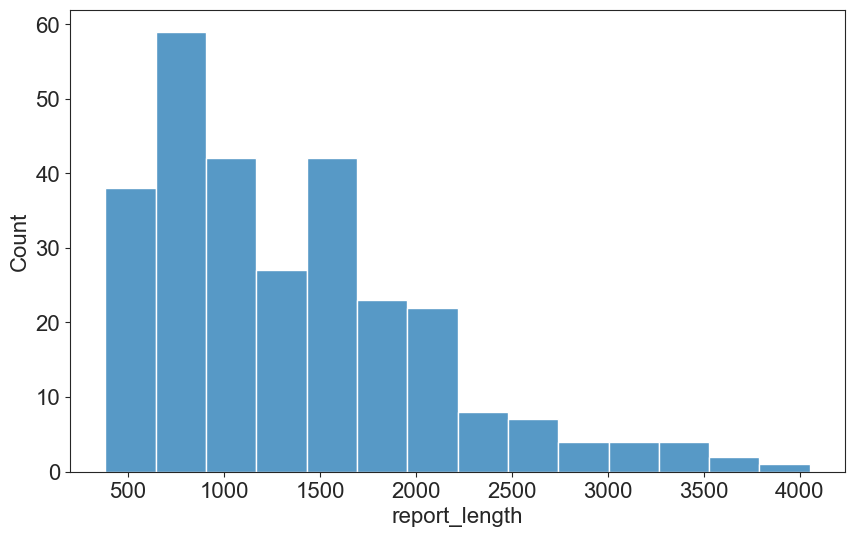

In [19]:
# Let's calculate the character length of reports
df['report_length'] = df.report.apply(len)

sns.histplot(x='report_length', data=df);

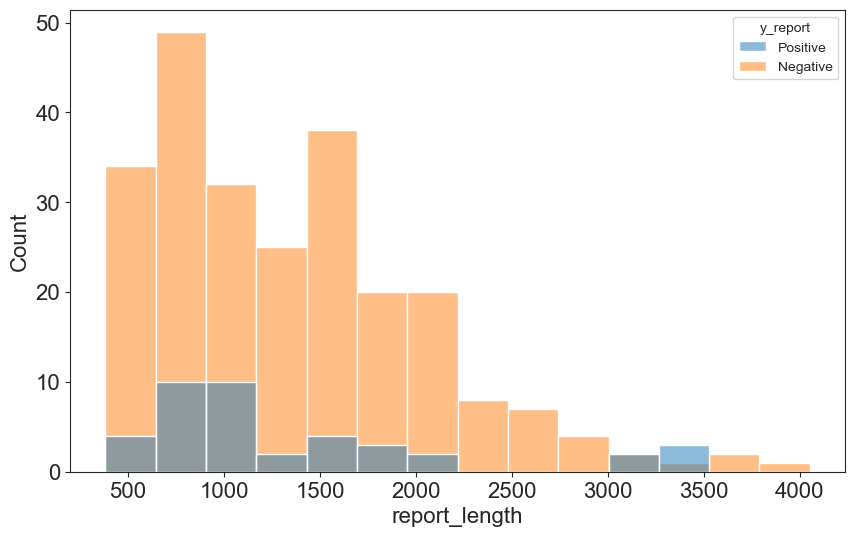

In [20]:
# Btw, is there any correlation between report length and its IFI label?
sns.histplot(x='report_length', data=df, hue='y_report');

___
# The annotation process

___
## What to annotate?

Now let's take a look at another report.

Assuming no prior knowledge, which words or phrases would you identify as __related to fungal infection__?

In [21]:
print(df.report.iloc[2])

"URNO         XXXXXXXXX Lab No    XXXXXXXXX        Specimen  BAL 


CLINICAL NOTES: 
Lung Mass. 
?fungal ?malignant. 

MACROSCOPIC DESCRIPTION: 
RUL bronchoalveolar lavage: 1.5ml slightly cloudy fluid. 

MICROSCOPIC DESCRIPTION: 
The smears contain scattered alveolar macrophages, few lymphocytes and neutrophils and abundant bronchial cells. No Pneumocystis or other fungal elements are identified on the Grocott stain. There is no evidence of Pneumocystis jiroveci or fungal 
elements. No malignant cells are present. 

DIFFERENTIAL CELL COUNT      %   REFERENCE RANGE 
Alveolar macrophages          84%       (83-94%) 
Lymphocytes                10%        (5-16%) 
Neutrophils                 1%        (1-6%) 
Eosinophils                  0%        (0-1%) 
Bronchial cells                5%        (0-5%) 

DIAGNOSIS: 
RUL bronchoalveolar lavage: Normal cell count. "



<div class="alert alert-block alert-info">
<li>The doctor suspects fungal infection: <code>?fungus</code></li>
<br/>
<li>Explicit negation of fungal infection: <code>no ... fungal elements are identified</code>, <code>no evidence of ... fungal elements</code></li>
<br/>
<li>What else? <code>Pneumocystis</code> is a type of fungi. <code>Grocott</code> is a dye that stains fungi.</li>
</div>

___
## The annotation schema

From what we have seen above, what information in the report is **relevant to detecting fungal infection**?

- Did the referring doctor suspect fungal infection?
- What stains were used to examine the sample?
- What organisms/species were mentioned?
- Were these explicitly negated?

How can we **categorise this information**? Let's define several concept categories: 

| **Concept category** | **Definition**                                                 |
|:----------------------:|:----------------------------------------------------------------|
| _ClinicalQuery_      | Queries about IFI                                              |
| _FungalDescriptor_   | Generic descriptors of fungal elements                         |
| _Fungus_             | Specific fungal organisms or syndromes                         |
| _Invasiveness_       | Depth and degree of fungal invasion into tissues               |
| _Stain_              | Names of histological stains used to visualise fungal elements |
| _SampleType_         | Names of the sampled organ, site, or tissue source             |
| _Positive_           | Affirmative expression                                         |
| _Equivocal_          | Expression of uncertainty                                      |
| _Negative_           | Negating expression                                            |

The phrases we have identified in our example would fall into the following categories:
- `?fungal` is a _ClinicalQuery_
- `fungal elements` is a _FungalDescriptor_ (**note** that both instances are negated)
- `Pneumocystis` is a _Fungus_
- `Grocott` is a _Stain_
- `no` and `no evidence of` is are both _Negative_

Now, if we were to encounter a **new report**, we would be able to identify and categorise these phrases. Take a look at the report below, do you think it is positive or negative for fungal infection?

In [22]:
print(df.loc[25].report)

"URNO     XXXXXXXXX 
Lab No    XXXXXXXXX        Specimen  BRONCHIAL WASHING 


CLINICAL NOTES: 
Immunosuppressed. Infiltrate. 

MACROSCOPIC DESCRIPTION: 
RLL bronchial washings: 2ml slightly blood stained mucoid fluid. 
NOTE: Specimen not labelled as to site. 

MICROSCOPIC DESCRIPTION: 
The smear contains scattered fungal hyphae. They appear thick, non-septate and branch at 90 degrees. The morphology is suggestive of Aspergillus. No viral inclusions are seen. The background contains occasional metaplastic cells, reactive pneumocytes, 
pigmented macrophages, degenerate cells and granular debris. There is no evidence of Pneumocystis jiroveci. No malignant cells are identified. 

DIAGNOSIS: 
RLL bronchial washings: No evidence of malignancy. Fungal elements resembling Aspergillus identified. "



<div class="alert alert-block alert-info">
Already familiar to us are the phrases <code>Pneumocystis</code>, which is a type of <i>Fungus</i>, and <code>fungal elements</code> categorised as <i>FungalDescriptor</i>. The report clearly states that <code>there is no evidence of Pneumocystis</code>.
</div>

If at this point we were to ask a medical professional to **help us find other mentions of fungal infection**, they would point us to phrases:
- `fungal hyphae`
- `thick, non-septate and branch at 90 degrees`
- `Aspergillus` 

The first two would be tagged as _FungalDescriptor_ and the latter as a type of _Fungus_.

<div class="alert alert-block alert-info">
With this <b>additional knowledge</b> we can now confidently say that the report is positive for fungal infection: <code>the smear contains scattered fungal hyphae</code> and <code>fungal elements resembling Aspergillus identified</code> both suggest there is something going on. 
</div>

___
## Annotations in the CHIFIR dataset

The example above showed us why it is important to look through multiple reports to **collect as much information as possible**.

Luckily, some kind medical professionals agreed to annotate all of our 283 reports tagging words and phrases that belong to one of the concept categories. We refer to these as the **gold standard**. Let's take a look at what was annotated:

In [17]:
# Parse annotation files and load gold standard annotations
concepts = utils.read_annotations(df, path)

Below is a table summarising how common are the concept categories and how much the language used varies within each category.

| **Concept category** | **Examples** | **Total occurrences** | **Number of reports with at least one occurrence**| **Number of unique phrases** | **Lexical diversity** |
|:----------------------:|:--------------------------------------------------------|:---:|:---:|:---:|:---:|
| _ClinicalQuery_      | ?cryptococcus, ?fungal infection|65|53|36|0.55|
| _FungalDescriptor_   | budding yeasts, fungal hyphae, pathogenic organisms|282|128|67|0.24|
| _Fungus_             | aspergillus, candida, cryptococcal organisms|106|60|15|0.14|
| _Invasiveness_       | angioinvasion, infiltration, intravascular spaces|37|12|25|0.68|
| _Stain_              | alcian blue, d/pas, grocott, mucicarmine|172|100|13|0.08|
| _SampleType_         | abdomen, cheek, lung, lymph node, skin|198|179|55|0.28|
| _Positive_           | containing, favouring, resembling, suggestive|118|42|37|0.31|
| _Equivocal_          | atypical, possibility, possible|7|5|5|0.71|
| _Negative_           | do not feature, failed to identify, no evidence, not seen|152|104|11|0.07|










<div class="alert alert-block alert-success">    
<h2>Considerations when doing NER</h2>
<br/>
<li><b>The size of the datase:</b> We only have 283 reports and some concept categories (e.g., <i>Equivocal</i>) are very rare.</li>
<br/>
<li><b>Lexical diversity:</b> There may be more than one way to say the same thing. <i>Stain</i> and <i>Negative</i> are looking good, <i>ClinicalQuery</i> and <i>Invasiveness</i> are going to be tricky.</li>
<br/>
<li><b>Very specific/narrow subject / Limited utility:</b> Pre-trained models / terminology sets are likely to be too generic.</li>
</div>

___
# NER

___
## Dictionary-based approach

### How does it work?

Think back to our example. Let's construct a dictionary of possible phrases for each concept category. Here is what our dictionary would look like after parsing the first report:
-  _ClinicalQuery_: `?fungal`
-  _FungalDescriptor_: `fungal elements`
-  _Fungus_: `Pneumocystis`
-  _Stain_: `Grocott`

After reading through the second report, we can add a few more phrases to our dictionary:
-  _ClinicalQuery_: `?fungal`
-  _FungalDescriptor_: `fungal elements`, `fungal hyphae`, `thick, non-septate and branch at 90 degrees`
-  _Fungus_: `Pneumocystis`, `Aspergillus`
-  _Stain_: `Grocott`

<div class="alert alert-block alert-info">
Now, if we were to stop here, these two reports would constitute the <b>training set</b> and the updated dictionary would be our <b>learned dictionary</b>. The remaining unseen 281 reports would be the <b>test set</b>. Alternatively, we can continue updating the dictionary by parsing addtional reports. 
</div>

### Once we have learned the dictionary

Here are the steps to apply it to an **unseen report**:
- Tokenise the report in the same manner as the reports in the training set.
- Scan the report to find tokens that match the learned dictionary.
- If there is a match, record the start and the end character positions and the concept category. 

### What to expect?
- Poor performace if the **training set is too small**.
- Poor performance if **lexical diversity is high**. This includes **spelling mistakes!**
- Good performance if the **language is consistent** and if **context does not play a big part**.
- **Very easy to interpret**. Good if you want to be able to visualise the workings of your NER and present it to non-tech audiences. 

### Let's run it

___
## Conditional random fields (CRF) model

### How does it work?

Let's think a bit about the **context**. 

Some phases are unambiguous, such as scientific names of fungal species. Others are open to more than one interpretation, for example, the word `organisms` might refer to a fungal, bacterial, or possibly viral infection.
- While the dictionary-based approach might know to recognise `fungal organisms`, a slightly more complex phrase `organisms of fungal origin`, if not seen before, would present a challenge. 
- Same goes for false positives: we would not want to pick up `organisms` if the context it is mentioned in has nothing to do with fungal infection. 

<div class="alert alert-block alert-info">
A CRF model allows to incorporate <b>contextual features</b> to address this polysemy. The goal here is to augment a given word with attributes describing its position in the text and spatial (contextual) relation to other words in the document. 
</div>

### Which features to include?

In this exercise we included the following word attributes:
- The start and end character positions
- Capitalisation patterns (i.e., if the word starts with a capital letter, is uppercased, lowercased, or has alternating casing)
- Morphologic patterns (i.e., word prefixes and suffixes)
- Numeric and punctuation patterns (i.e., if the word contains any digits, hyphens, etc.)

Other common attributes are: **part-of-speech tags**, **sentence-level position**, **preceeding and following words**.

### How to apply to new data?
Here are the key steps to apply CRF NER to an **unseen report**:
- Tokenise the report in the same manner as the reports in the training set.
- For each token, calculate 
- Scan the report to find tokens that match the learned dictionary.
- If there is a match, record the start and the end character positions and the concept category.

### What to expect?

- Good performance when **linguistic structure is consistent**
- Poor performance if the included **attributes are not predcitive**
- Poor performance if **attributes are not computable**

___
## Transformer-based model


**How does it work?**

**How to apply to new data?**

**What to expect?**

**Results**



- Results
- Pros & Cons

- Equivocal/positive terms: can we implement "uncertainty"/"affirmation" detection?
- How to pre-annotate the data? E.g., use Metamap then feed into clinicians.
- Tools for NER: medcat, MetaMap, etc
- Can mention relation extraction, concept linking. Give pointers

<!-- **What's in the learned dictionary?**

There are a couple of things we need to keep track of when learning a dictionary:
- The annotated phrase (e.g., `fungal hyphae`)
- The assigned concept category (e.g., _FungalDescriptor_)
- The start and end character positions (e.g., 150 and 163) -->